In [1]:

using Pkg
Pkg.activate("./baron_env")
#Pkg.pin("JuMP")
using JuMP
using CSV
using GraphRecipes, Plots
using LightGraphs
using LinearAlgebra
using SparseArrays
using DataFrames
using BARON
using PiecewiseLinearOpt


  Activating environment at `~/Documents/project-codes/Plan_RoadmapsIAM/toy-problem/baron_env/Project.toml`


In [2]:
Pkg.installed()

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Pkg/src/Pkg.jl:570


Dict{String, VersionNumber} with 3 entries:
  "BARON"              => v"0.6.5"
  "PiecewiseLinearOpt" => v"0.3.0"
  "CPLEX"              => v"0.7.8"

In [3]:
innovations = CSV.File("./data/innovations.csv",header=1,delim=",") |> DataFrame
mapki = CSV.File("./data/map-ki.csv",header=1,delim=",") |> DataFrame
compromise = CSV.File("./data/compromise.csv",header=1,delim=",") |> DataFrame
initial = CSV.File("./data/initial.csv",header=1,delim=",") |> DataFrame
iam_model = CSV.File("./data/iam_model.csv",header=1,delim=",") |> DataFrame
ci=innovations[!,2]
rl=innovations[!,3]
initial

#innovations[2,6]=7
#compromise[!,3]=compromise[!,3]/2
#innovations[2,2]=175
innovations[2,2]=205
#innovations[2,3]=2
#innovations[1,3]=3
#innovations[4,2]=108

#innovations[1,2]=185
#innovations[3,3]=2
innovations
#CSV.write("innovations.csv",innovations)

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,92,3,4.6,1.34,2.04,0.12,8.86,0
2,2,205,2,8.32,8.84,0.65,9.9,9.65,0
3,3,84,1,4.44,1.21,5.09,6.52,8.67,0
4,4,108,3,5.48,7.62,3.34,5.05,1.1,0
5,5,80,1,9.94,2.38,7.94,3.82,5.44,0


In [4]:
compromise

,k,i,GWP,Theta,Per_Recycl,Per_Comp,GHG_ElecInd,GHG_Trans
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,40.0,0.6,0.5,0.0,0.301222,0.162415
2,2,1,43.0,0.66,0.55,0.0,0.291677,0.145083
3,3,1,45.5,0.68,0.567,0.0,0.323371,0.161281
4,4,1,47.5,0.7,0.583,0.0,0.525025,0.151392
5,5,2,30.0,0.4,0.0,0.2,0.308217,0.0923318
6,6,2,32.0,0.48,0.0,0.24,0.419839,0.167281
7,7,2,34.0,0.5,0.0,0.27,0.418893,0.136562
8,8,2,38.0,0.52,0.0,0.34,0.530551,0.134121
9,9,2,40.0,0.54,0.0,0.37,0.418593,0.146208


In [5]:
function get_transition_mat(i)
    p_mat=reshape(collect(innovations[i,9:33]),5,5)
    return p_mat'
end


function get_rate_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return q_mat
end

function get_rate_eig_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return [q_mat,eigvecs(q_mat),eigvals(q_mat)]
end

function get_IAM_factor(t)
    return 1
end

function give_sorted(t)
    v=sortperm(t)
    return v
end


give_sorted (generic function with 1 method)

In [6]:
q=zeros(5,5,nrow(innovations))
a=zeros(5,5,nrow(innovations))
ainv=zeros(5,5,nrow(innovations))
d=zeros(5,1,nrow(innovations))
s0=zeros(1,5,nrow(innovations))
for i in 1:nrow(innovations)
    q[:,:,i]=round.(get_rate_eig_mat(i)[1],digits=3)
    a[:,:,i]=(get_rate_eig_mat(i)[2])
    d[:,:,i]=round.(get_rate_eig_mat(i)[3],digits=3)
    ainv[:,:,i]=round.(inv(get_rate_eig_mat(i)[2]),digits=3)
    s0[1,rl[i],i]=1
end
rl_vals=[1 2 3 4 5]

1×5 Matrix{Int64}:
 1  2  3  4  5

In [7]:
inn_reg = CSV.File("./data/inn_reg.csv",header=1,delim=",") |> DataFrame
inn_xrang = CSV.File("./data/inn_xrang.csv",header=1,delim=",") |> DataFrame
inn_yrang = CSV.File("./data/inn_yrang.csv",header=1,delim=",") |> DataFrame
inn_yrang[!,"Y0"]=-1*(innovations[!,"RL"].-5)
inn_yrang

,Column1,Y0,Y1,Y2,Y3,Y4,Y5
,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,1,2,2.7072,4.75873,7.09603,9.8417,13.0938
2,2,3,3.57175,4.12,4.85225,5.7275,6.88619
3,3,4,3.27231,3.46135,4.85452,6.94432,9.60523
4,4,2,3.57586,4.52541,5.81029,7.27062,8.80461
5,5,4,3.61235,3.77839,4.54485,5.90837,7.67768


In [8]:
A=[1 2 4;2 3 5;4 5 1]
A^-1 * [1;3;4]


3-element Vector{Float64}:
  3.999999999999999
 -2.5
  0.5

In [9]:
A=[ [1 0 -20 -40 0 30 45 0 0];
    [0 1 -1 -2 0 0 0 0 0.1];
    [0 0 100 0 -1 0 0 0 0];
    [0 0 0 100 -1 0 0 0 0];
    [0 0 0 0 1 0 0 -30 -20];
    [0 0 0 0 0 -50 -50 22 0]]

B=[[0.25 0.2 2 1 0 2 5 1 1];
    [0 0 0 0 0.4 5 5 0 2];
    [0 0 0 0 0 15 0 8 5]]

m=[0.2 0.4]

1×2 Matrix{Float64}:
 0.2  0.4

In [10]:
A

6×9 Matrix{Float64}:
 1.0  0.0  -20.0  -40.0   0.0   30.0   45.0    0.0    0.0
 0.0  1.0   -1.0   -2.0   0.0    0.0    0.0    0.0    0.1
 0.0  0.0  100.0    0.0  -1.0    0.0    0.0    0.0    0.0
 0.0  0.0    0.0  100.0  -1.0    0.0    0.0    0.0    0.0
 0.0  0.0    0.0    0.0   1.0    0.0    0.0  -30.0  -20.0
 0.0  0.0    0.0    0.0   0.0  -50.0  -50.0   22.0    0.0

In [11]:
function tech_roadmap_mccormick_peicewise_self()
    
    rdmap= Model(BARON.Optimizer)
    set_optimizer_attribute(rdmap, "MaxTime", 2500)
    
    #Sets
    # i: innovation
    # k: compromise or pareto optimal solution
    # r,c : row column of transition matrices
    
    #Declaration of variables
    
    #binary variable choosing the pareto optimal solution
    @variable(rdmap,yk[k=1:nrow(compromise)],Bin)
    #time at which a pareto optimal solution is chosen
    @variable(rdmap,0 ≤ tk[k=1:nrow(compromise)] ≤ 50)
    #percentage of functional unit that a pareto optimal solution takes up
    @variable(rdmap,0 ≤ xk[k=1:nrow(compromise)] ≤ 1)
    
    #binary variable choosing which innovation to invest in for adoption
    @variable(rdmap,yi[i=1:nrow(innovations)],Bin)
    #time at which invested is made and innovation made adoptible
    @variable(rdmap,0 ≤ ti[i=1:nrow(innovations)] ≤ 50)
    #readiness level state value of ith innovation
    @variable(rdmap, s[i=1:nrow(innovations)] )
    
    #CO2 at 2050 target
    @variable(rdmap, co2_2050 ≥ 0)
    
    #circularity at 2030 target
    @variable(rdmap, theta_2030 ≥ 0)
    #recycled content at 2030 target
    @variable(rdmap, recycl_2030 ≥ 0)
    #compostable content at 2030 target
    @variable(rdmap, comp_2030 ≥ 0)
    
    #integral approximator of CO2
    @variable(rdmap, co2_tot ≥ 0)
    
    #cost incured in investing to adopt
    @variable(rdmap, 0 ≤ cost_inn)
    
    
    #Constraints
    
    #Planning optimization constraints    
    #only one compromise solution chosen on each pareto front, and chosen only if investment made in ith front
    @constraint(rdmap, [i=1], sum(yk[k] for k=1:mapki[i,2])==yi[i])
    @constraint(rdmap, [i=2:nrow(mapki)], sum(yk[k] for k=mapki[i-1,2]:mapki[i,2])==yi[i])
    
    #one can pick a compromise solution from ith front to satisfy functional unit only after investment in ith innovation made
    @constraint(rdmap, [i=1], ti[i] ≤ sum(tk[k] for k=1:mapki[i,2]))
    @constraint(rdmap, [i=2:nrow(mapki)], ti[i] ≤ sum(tk[k] for k=mapki[i-1,2]:mapki[i,2]))
    
    #if innovation invested in, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≥ ti[i])
    #if compromise solution chosen, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≥ tk[k])
    
    #if innovation invested in, time has to be between 0 and fifty, otherwise 0
    #@constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≤ ti[i])
    #if compromise solution chosen, time has to be between 0 and fifty, otherwise 0
    #@constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≤ tk[k])
    
    
    #functional unit allocation to innovation iff compromise solution chosen
    @constraint(rdmap, [k=1:nrow(compromise)], yk[k] ≥ xk[k])
    
    #total fraction of functional unit satisfied by innovative compromise solutions <1
    @constraint(rdmap, sum(xk[k] for k in 1:nrow(compromise)) ≤ 1) 
    
    #co2 at 2050 target formulated based on distribution of functional unit to various pareto solutions from innovative and conventional fronts
    @constraint(rdmap, co2_2050==sum(xk[k]*compromise[k,3] for k in 1:nrow(compromise))
        + (1-sum(xk[k] for k in 1:nrow(compromise)))*initial[1,3])
    
    #tk < 30
    @variable(rdmap, zk_2030[k=1:nrow(compromise)], Bin)
    @constraint(rdmap, [k=1:nrow(compromise)], 50*(1-zk_2030[k]) ≥ tk[k]-10)
    
    #circularity at 2030 target
    @constraint(rdmap, theta_2030==sum(xk[k]*compromise[k,4]*(zk_2030[k]) for k in 1:nrow(compromise))
        + (1-sum(xk[k]*(zk_2030[k]) for k in 1:nrow(compromise)))*initial[1,4])
    
    #recyclable content at 2030 target
    @constraint(rdmap, recycl_2030==sum(xk[k]*compromise[k,5]*(zk_2030[k]) for k in 1:nrow(compromise))
        + (1-sum(xk[k]*(zk_2030[k]) for k in 1:nrow(compromise)))*initial[1,5])
    
    #compostable at 2030 target
    @constraint(rdmap, comp_2030==sum(xk[k]*compromise[k,6]*(zk_2030[k]) for k in 1:nrow(compromise))
        + (1-sum(xk[k]*(zk_2030[k]) for k in 1:nrow(compromise)))*initial[1,6])
    
    
    #Time evolution of innovation
   
    
    #Integral approximation of co2 emitted during the entire time horizon
    
    #mccormick envelopes reduces computational time by 3 fold (see previous formulation for actual bilinear integral approximation)
    @variable(rdmap,0 ≤ wk[k=1:nrow(compromise)])
    @constraint(rdmap,[k=1:nrow(compromise)],wk[k] ≥ 50*xk[k]+tk[k]-50)
    @constraint(rdmap,[k=1:nrow(compromise)],wk[k] ≤ 50*xk[k])
    @constraint(rdmap,[k=1:nrow(compromise)],wk[k] ≤ tk[k])
    
    @NLconstraint(rdmap, co2_tot == 50*initial[1,3]-sum((50-tk[k])*xk[k]*(initial[1,3]-compromise[k,3]) for k in 1:nrow(compromise)))
    #@constraint(rdmap, co2_tot == 50*initial[1,3]-sum((50*xk[k]-wk[k])*(initial[1,3]-compromise[k,3]) for k in 1:nrow(compromise)))

    #setting target for 2050 co2 pledge
    @constraint(rdmap, co2_2050 ≤ 42)
    
    #setting target for 2030 circularity pledge
    #@constraint(rdmap, theta_2030 ≥ 0.72)
    
    #setting target for 2030 recycl pledge
    @constraint(rdmap, recycl_2030 + comp_2030 ≥ 0.75)
    #0.42 co2 0.3 recycl
    
    #setting target for 2030 comp pledge
    #@constraint(rdmap, comp_2030 ≥ 0.0)
    
    
    @variable(rdmap,f_fit[i=1:nrow(innovations)] ≥ 0)

    for i in 1:nrow(innovations)
        f_fit[i] = piecewiselinear(rdmap, ti[i], Matrix(inn_xrang[!,2:ncol(inn_xrang)])[i,:],Matrix(inn_yrang[!,2:ncol(inn_yrang)])[i,:])
    end

    
    @NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*f_fit[i]) for i in 1:nrow(innovations)))
                

    
    @constraint(rdmap, [i=1:nrow(innovations)],s[i]==f_fit[i])
    
    #@variable(rdmap, y1, Bin)
    #@NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*(y1*(2*t/50)+(1-y1)*(3*t/50))) for i in 1:nrow(innovations)))
    
    

    #definining objective function as investment cost + Co2 emission cost during the time horizon
    #40*0.001*co2_tot+
    #@NLconstraint(rdmap, obj_val == cost_inn)
    @NLobjective(rdmap,Min, 120*0.001*co2_tot+cost_inn)
    #supplying lower bound on objective based on cost_inn optimal
    #@variable(rdmap, obj_val ≥ 180)
    #print(rdmap)
    optimize!(rdmap)
    
    return JuMP.value.(yk), JuMP.value.(tk), JuMP.value.(xk), JuMP.value.(yi), JuMP.value.(ti), 
        JuMP.value.(s), JuMP.value.(co2_2050), JuMP.value.(cost_inn), JuMP.value.(co2_tot)
end




tech_roadmap_mccormick_peicewise_self (generic function with 1 method)

In [12]:
yk, tk, xk, yi, ti, s, co2, costInn, co2tot=tech_roadmap_mccormick_peicewise_self()
yi


 BARON version 21.1.13. Built: LNX-64 Wed Jan 13 16:09:31 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Bhavik R. Bakshi at The Ohio State University, bakshi.2@osu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Kilinc, M. and N. V. Sahinidis, Exploiting integrality in the global
 optimization of mixed-integer nonlinear programming problems in BARON,
 Optimization Methods and Software, 33, 540-562, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory
 Solving bounding LP
 Starting multi-start local se

5-element Vector{Float64}:
 1.0
 0.0
 1.0
 0.0
 0.0

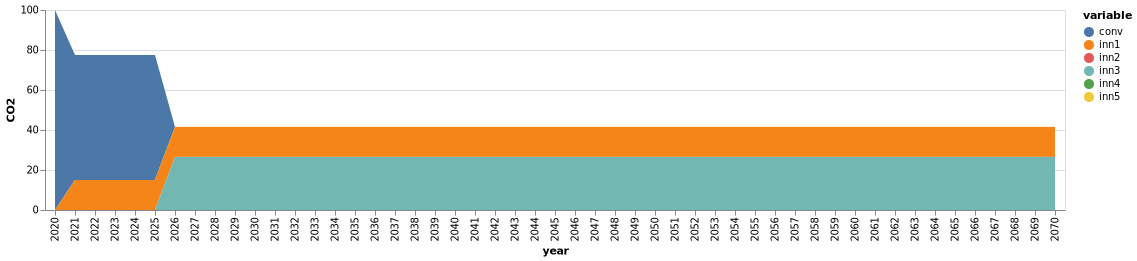

In [51]:
function conventional(t)
    return initial[1,3]*(1-sum(JuMP.values.(xk)[k] for k in 1:nrow(compromise) if t>JuMP.values.(tk)[k]))
end

function innovation(i,t)
    if i==1
        return sum(JuMP.values.(xk)[k]*(compromise[k,3]) for k=1:mapki[i,2] if t>JuMP.values.(tk)[k])
    else
        return sum(JuMP.values.(xk)[k]*(compromise[k,3]) for k=mapki[i-1,2]:mapki[i,2] if t>JuMP.values.(tk)[k])
    end
end

conv=zeros(51)

conv[1]=initial[1,3]
inn_co2=zeros(5,51)

for inn in 1:5
    inn_co2[inn,1]=0
end

for i in 2:51
    conv[i]=conventional(i)
    for inn in 1:5
        inn_co2[inn,i]=innovation(inn,i)
    end
end
conv

sNames = ["conv","inn1","inn2","inn3","inn4","inn5"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],inn5=inn_co2[5,:])

df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="CO2"}, color="variable:n",legend=:sNames) 

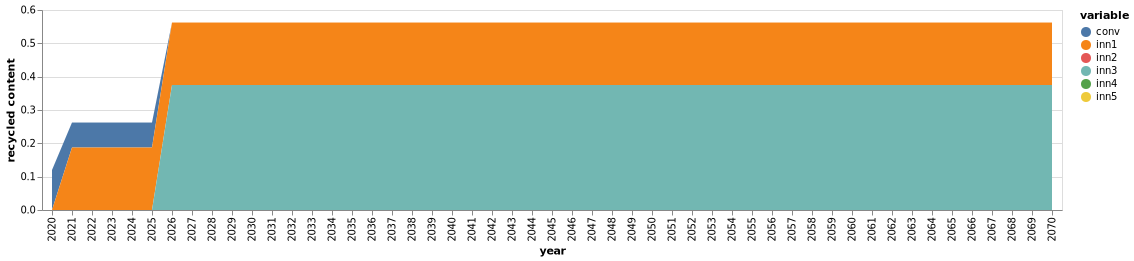

In [52]:
function conventional(t)
    return initial[1,5]*(1-sum(JuMP.values.(xk)[k] for k in 1:nrow(compromise) if t>JuMP.values.(tk)[k]))
end

function innovation(i,t)
    if i==1
        return sum(JuMP.values.(xk)[k]*(compromise[k,5]) for k=1:mapki[i,2] if t>JuMP.values.(tk)[k])
    else
        return sum(JuMP.values.(xk)[k]*(compromise[k,5]) for k=mapki[i-1,2]:mapki[i,2] if t>JuMP.values.(tk)[k])
    end
end

conv=zeros(51)

conv[1]=initial[1,5]
inn_co2=zeros(5,51)

for inn in 1:5
    inn_co2[inn,1]=0
end

for i in 2:51
    conv[i]=conventional(i)
    for inn in 1:5
        inn_co2[inn,i]=innovation(inn,i)
    end
end
conv

sNames = ["conv","inn1","inn2","inn3","inn4","inn5"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],inn5=inn_co2[5,:])

df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="recycled content"}, color="variable:n",ylab="circularity") 

In [40]:
conv

51-element Vector{Float64}:
 100.0
  85.0
  85.0
  85.0
  85.0
  85.0
  58.4375
  58.4375
  58.4375
  58.4375
  58.4375
  58.4375
  58.4375
   ⋮
  58.4375
  58.4375
  58.4375
  58.4375
  58.4375
  58.4375
  58.4375
  58.4375
  58.4375
  58.4375
  58.4375
  58.4375

In [13]:
ti


5-element Vector{Float64}:
 0.0
 0.0
 6.250000000000002
 0.0
 0.0

In [14]:
costInn

458.87406914637427

In [15]:
tk

25-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 6.250000000000002
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [16]:
co2tot*40*0.001

92.109375

In [17]:
yi

5-element Vector{Float64}:
 1.0
 0.0
 1.0
 0.0
 0.0

In [18]:
tk

25-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 6.250000000000002
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [19]:
xk


25-element Vector{Float64}:
 0.375
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.625
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [20]:
yk

25-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [21]:
s

5-element Vector{Float64}:
 2.0
 3.0
 3.272310346980646
 2.0
 4.0

In [22]:
compromise

,k,i,GWP,Theta,Per_Recycl,Per_Comp,GHG_ElecInd,GHG_Trans
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,40.0,0.6,0.5,0.0,0.301222,0.162415
2,2,1,43.0,0.66,0.55,0.0,0.291677,0.145083
3,3,1,45.5,0.68,0.567,0.0,0.323371,0.161281
4,4,1,47.5,0.7,0.583,0.0,0.525025,0.151392
5,5,2,30.0,0.4,0.0,0.2,0.308217,0.0923318
6,6,2,32.0,0.48,0.0,0.24,0.419839,0.167281
7,7,2,34.0,0.5,0.0,0.27,0.418893,0.136562
8,8,2,38.0,0.52,0.0,0.34,0.530551,0.134121
9,9,2,40.0,0.54,0.0,0.37,0.418593,0.146208


In [23]:
Matrix(inn_xrang[!,2:ncol(inn_xrang)])[:,1]

5-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0

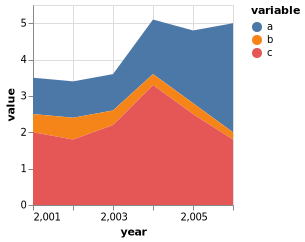

In [28]:
using VegaLite, VegaDatasets
using FileIO
a = [1,1,1,1.5,2,3]
b = [0.5,0.6,0.4,0.3,0.3,0.2]
c = [2,1.8,2.2,3.3,2.5,1.8]
sNames = ["a","b","c"]
xLabels = [2001,2002,2003,2004,2005,2006]

df = DataFrame(year=xLabels, a=a, b=b, c=c)

df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero}, color="variable:n") 

In [35]:
function tech_roadmap_mccormick_peicewise_iam()
    
    rdmap= Model(BARON.Optimizer)
    set_optimizer_attribute(rdmap, "MaxTime", 2500)
    
    #Sets
    # i: innovation
    # k: compromise or pareto optimal solution
    # r,c : row column of transition matrices
    
    #Declaration of variables
    
    #binary variable choosing the pareto optimal solution
    @variable(rdmap,yk[k=1:nrow(compromise)],Bin)
    #time at which a pareto optimal solution is chosen
    @variable(rdmap,0 ≤ tk[k=1:nrow(compromise)] ≤ 50)
    #percentage of functional unit that a pareto optimal solution takes up
    @variable(rdmap,0 ≤ xk[k=1:nrow(compromise)] ≤ 1)
    
    #binary variable choosing which innovation to invest in for adoption
    @variable(rdmap,yi[i=1:nrow(innovations)],Bin)
    #time at which invested is made and innovation made adoptible
    @variable(rdmap,0 ≤ ti[i=1:nrow(innovations)] ≤ 50)
    #readiness level state value of ith innovation
    @variable(rdmap, s[i=1:nrow(innovations)] )
    
    #CO2 at 2050 target
    @variable(rdmap, co2_2050 ≥ 0)
    
    #circularity at 2030 target
    @variable(rdmap, theta_2030 ≥ 0)
    #recycled content at 2030 target
    @variable(rdmap, recycl_2030 ≥ 0)
    #compostable content at 2030 target
    @variable(rdmap, comp_2030 ≥ 0)
    
    #integral approximator of CO2
    @variable(rdmap, co2_tot ≥ 0)
    
    #cost incured in investing to adopt
    @variable(rdmap, 0 ≤ cost_inn)
    
    #surrogate models
    @variable(rdmap,f_fit[i=1:nrow(innovations)] ≥ 0)
    @variable(rdmap,co2_factor[k=1:nrow(compromise)]≥ 0)
    @variable(rdmap,co2_corrected[k=1:nrow(compromise)]≥ 0)

    for i in 1:nrow(innovations)
        f_fit[i] = piecewiselinear(rdmap, ti[i], Matrix(inn_xrang[!,2:ncol(inn_xrang)])[i,:],Matrix(inn_yrang[!,2:ncol(inn_yrang)])[i,:])
    end
    
    for k in 1:nrow(compromise)
        co2_factor[k] = (piecewiselinear(rdmap, tk[k], Matrix(iam_model[!,1:1])[:,1],Matrix(iam_model[!,2:2])[:,1]))
    end
    
    @constraint(rdmap, [k=1:nrow(compromise)], co2_corrected[k] == 
        compromise[k,3]*((1-compromise[k,7]) + compromise[k,7]*(1-co2_factor[k])))
    
    #Constraints
    
    
    #Planning optimization constraints    
    #only one compromise solution chosen on each pareto front, and chosen only if investment made in ith front
    @constraint(rdmap, [i=1], sum(yk[k] for k=1:mapki[i,2])==yi[i])
    @constraint(rdmap, [i=2:nrow(mapki)], sum(yk[k] for k=mapki[i-1,2]:mapki[i,2])==yi[i])
    
    #one can pick a compromise solution from ith front to satisfy functional unit only after investment in ith innovation made
    @constraint(rdmap, [i=1], ti[i] ≤ sum(tk[k] for k=1:mapki[i,2]))
    @constraint(rdmap, [i=2:nrow(mapki)], ti[i] ≤ sum(tk[k] for k=mapki[i-1,2]:mapki[i,2]))
    
    #if innovation invested in, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≥ ti[i])
    #if compromise solution chosen, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≥ tk[k])
    
    #if innovation invested in, time has to be between 0 and fifty, otherwise 0
    #@constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≤ ti[i])
    #if compromise solution chosen, time has to be between 0 and fifty, otherwise 0
    #@constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≤ tk[k])
    
    
    #functional unit allocation to innovation iff compromise solution chosen
    @constraint(rdmap, [k=1:nrow(compromise)], yk[k] ≥ xk[k])
    
    #total fraction of functional unit satisfied by innovative compromise solutions <1
    @constraint(rdmap, sum(xk[k] for k in 1:nrow(compromise)) ≤ 1) 
    
    #co2 at 2050 target formulated based on distribution of functional unit to various pareto solutions from innovative and conventional fronts
    @constraint(rdmap, co2_2050==sum(xk[k]*co2_corrected[k] for k in 1:nrow(compromise))
        + (1-sum(xk[k] for k in 1:nrow(compromise)))*initial[1,3])
    
    #tk < 30
    @variable(rdmap, zk_2030[k=1:nrow(compromise)], Bin)
    @constraint(rdmap, [k=1:nrow(compromise)], 50*(1-zk_2030[k]) ≥ tk[k]-40)
    
    #circularity at 2030 target
    @constraint(rdmap, theta_2030==sum(xk[k]*compromise[k,4]*(zk_2030[k]) for k in 1:nrow(compromise))
        + (1-sum(xk[k]*(zk_2030[k]) for k in 1:nrow(compromise)))*initial[1,4])
    
    #recyclable content at 2030 target
    @constraint(rdmap, recycl_2030==sum(xk[k]*compromise[k,5]*(zk_2030[k]) for k in 1:nrow(compromise))
        + (1-sum(xk[k]*(zk_2030[k]) for k in 1:nrow(compromise)))*initial[1,5])
    
    #compostable at 2030 target
    @constraint(rdmap, comp_2030==sum(xk[k]*compromise[k,6]*(zk_2030[k]) for k in 1:nrow(compromise))
        + (1-sum(xk[k]*(zk_2030[k]) for k in 1:nrow(compromise)))*initial[1,6])
    
    
    #Time evolution of innovation
   
    
    #Integral approximation of co2 emitted during the entire time horizon
    
    #mccormick envelopes reduces computational time by 3 fold (see previous formulation for actual bilinear integral approximation)
    @variable(rdmap,0 ≤ wk[k=1:nrow(compromise)])
    @constraint(rdmap,[k=1:nrow(compromise)],wk[k] ≥ 50*xk[k]+tk[k]-50)
    @constraint(rdmap,[k=1:nrow(compromise)],wk[k] ≤ 50*xk[k])
    @constraint(rdmap,[k=1:nrow(compromise)],wk[k] ≤ tk[k])
    
    @NLconstraint(rdmap, co2_tot == 50*initial[1,3]-sum((50-tk[k])*xk[k]*(initial[1,3]-co2_corrected[k]) for k in 1:nrow(compromise)))
    #@constraint(rdmap, co2_tot == 50*initial[1,3]-sum((50*xk[k]-wk[k])*(initial[1,3]-compromise[k,3]) for k in 1:nrow(compromise)))

    #setting target for 2050 co2 pledge
    @constraint(rdmap, co2_2050 ≤ 30)
    
    #setting target for 2030 circularity pledge
    #@constraint(rdmap, theta_2030 ≥ 0.72)
    
    #setting target for 2030 recycl pledge
    @constraint(rdmap, recycl_2030 ≥ 0.3)
    
    #setting target for 2030 comp pledge
    @constraint(rdmap, comp_2030 ≥ 0.45)
    
    


    
    @NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*f_fit[i]) for i in 1:nrow(innovations)))
                

    
    @constraint(rdmap, [i=1:nrow(innovations)],s[i]==f_fit[i])
    
    #@variable(rdmap, y1, Bin)
    #@NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*(y1*(2*t/50)+(1-y1)*(3*t/50))) for i in 1:nrow(innovations)))
    
    

    #definining objective function as investment cost + Co2 emission cost during the time horizon
    #40*0.001*co2_tot+
    #@NLconstraint(rdmap, obj_val == cost_inn)
    @NLobjective(rdmap,Min, 120*0.001*co2_tot+cost_inn)
    #supplying lower bound on objective based on cost_inn optimal
    #@variable(rdmap, obj_val ≥ 180)
    #print(rdmap)
    optimize!(rdmap)
    
    return JuMP.value.(yk), JuMP.value.(tk), JuMP.value.(xk), JuMP.value.(yi), JuMP.value.(ti), 
        JuMP.value.(s), JuMP.value.(co2_2050), JuMP.value.(cost_inn), JuMP.value.(co2_tot), JuMP.value.(co2_corrected)
end




tech_roadmap_mccormick_peicewise_iam (generic function with 1 method)

In [22]:
yk, tk, xk, yi, ti, s, co2, costInn, co2tot, co2fac=tech_roadmap_mccormick_peicewise_iam()
yi


 BARON version 21.1.13. Built: LNX-64 Wed Jan 13 16:09:31 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Bhavik R. Bakshi at The Ohio State University, bakshi.2@osu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Kilinc, M. and N. V. Sahinidis, Exploiting integrality in the global
 optimization of mixed-integer nonlinear programming problems in BARON,
 Optimization Methods and Software, 33, 540-562, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory
 Solving bounding LP
 Starting multi-start local se

5-element Vector{Float64}:
 0.0
 0.0
 1.0
 1.0
 0.0

In [49]:
tk

25-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 16.24999999999999
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [50]:
xk

25-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.5454545454545451
 0.0
 0.0
 0.0
 0.0
 0.454545454545455
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [49]:
function tech_roadmap_mccormick_peicewise_iam_breakpts()
    
    rdmap= Model(BARON.Optimizer)
    set_optimizer_attribute(rdmap, "MaxTime", 2500)
    
    #Sets
    # i: innovation
    # k: compromise or pareto optimal solution
    # r,c : row column of transition matrices
    B=3
    #Declaration of variables
    
    #binary variable choosing the pareto optimal solution
    @variable(rdmap,yk[b=1:B,k=1:nrow(compromise)],Bin)
    #time at which a pareto optimal solution is chosen
    @variable(rdmap,0 ≤ tk[b=1:B,k=1:nrow(compromise)] ≤ 50)
    #percentage of functional unit that a pareto optimal solution takes up
    @variable(rdmap,0 ≤ xk[b=1:B,k=1:nrow(compromise)] ≤ 1)
    
    #binary variable choosing which innovation to invest in for adoption
    @variable(rdmap,yi[i=1:nrow(innovations)],Bin)
    #time at which invested is made and innovation made adoptible
    @variable(rdmap,0 ≤ ti[i=1:nrow(innovations)] ≤ 50)
    #readiness level state value of ith innovation
    @variable(rdmap, s[i=1:nrow(innovations)] )
    
    #CO2 at 2050 target
    @variable(rdmap, co2_2050 ≥ 0)
    
    #circularity at 2030 target
    @variable(rdmap, theta_2030 ≥ 0)
    #recycled content at 2030 target
    @variable(rdmap, recycl_2030 ≥ 0)
    #compostable content at 2030 target
    @variable(rdmap, comp_2030 ≥ 0)
    
    #integral approximator of CO2
    @variable(rdmap, co2_tot ≥ 0)
    
    #cost incured in investing to adopt
    @variable(rdmap, 0 ≤ cost_inn)
    
    #surrogate models
    @variable(rdmap,f_fit[i=1:nrow(innovations)] ≥ 0)
    @variable(rdmap,co2_factor[b=1:B,k=1:nrow(compromise)]≥ 0)
    @variable(rdmap,co2_corrected[b=1:B,k=1:nrow(compromise)]≥ 0)

    for i in 1:nrow(innovations)
        f_fit[i] = piecewiselinear(rdmap, ti[i], Matrix(inn_xrang[!,2:ncol(inn_xrang)])[i,:],Matrix(inn_yrang[!,2:ncol(inn_yrang)])[i,:])
    end
    
    for b in 1:B
        for k in 1:nrow(compromise)
            co2_factor[b,k] = (piecewiselinear(rdmap, tk[b,k], Matrix(iam_model[!,1:1])[:,1],Matrix(iam_model[!,2:2])[:,1]))
        end
    end
    
    @constraint(rdmap, [b=1:B,k=1:nrow(compromise)], co2_corrected[b,k] == 
        compromise[k,3]*((1-compromise[k,7]) + compromise[k,7]*(1-co2_factor[b,k])))
    
    #Constraints
    
    
    #Planning optimization constraints    
    #only one compromise solution chosen on each pareto front, and chosen only if investment made in ith front
    @constraint(rdmap, [i=1], sum(yk[b,k] for k=1:mapki[i,2],b=1:B)≥ yi[i])
    @constraint(rdmap, [i=2:nrow(mapki)], sum(yk[b,k] for k=mapki[i-1,2]:mapki[i,2],b=1:B) ≥ yi[i])
    #@constraint(rdmap, [i=1,b=1:B], sum(yk[b,k] for k=1:mapki[i,2]) ≤ 1 )
    #@constraint(rdmap, [i=2:nrow(mapki),b=1:B], sum(yk[b,k] for k=mapki[i-1,2]:mapki[i,2]) ≤ 1)
    
    #one can pick a compromise solution from ith front to satisfy functional unit only after investment in ith innovation made
    @constraint(rdmap, [i=1], ti[i] ≤ sum(tk[b,k] for k=1:mapki[i,2],b=1:B))
    @constraint(rdmap, [i=2:nrow(mapki)], ti[i] ≤ sum(tk[b,k] for k=mapki[i-1,2]:mapki[i,2],b=1:B))
    
    #if innovation invested in, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≥ ti[i])
    #if compromise solution chosen, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [b=1:B,k=1:nrow(compromise)], 50*yk[b,k] ≥tk[b,k])
    @constraint(rdmap, [b=1:B,k=1:nrow(compromise)], (b-1)*50 ≤ B*tk[b,k] ≤ b*50)

    
    
    #if innovation invested in, time has to be between 0 and fifty, otherwise 0
    #@constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≤ ti[i])
    #if compromise solution chosen, time has to be between 0 and fifty, otherwise 0
    #@constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≤ tk[k])
    
    
    #functional unit allocation to innovation iff compromise solution chosen
    @constraint(rdmap, [b=1:B,k=1:nrow(compromise)], yk[b,k] ≥ xk[b,k])
    
    #total fraction of functional unit satisfied by innovative compromise solutions <1
    @constraint(rdmap, sum(xk[b,k] for k in 1:nrow(compromise),b in 1:B) ≤ 1) 
    
    #co2 at 2050 target formulated based on distribution of functional unit to various pareto solutions from innovative and conventional fronts
    @constraint(rdmap, co2_2050==sum(xk[B,k]*co2_corrected[B,k] for k in 1:nrow(compromise))
        + (1-sum(xk[B,k] for k in 1:nrow(compromise)))*initial[1,3])
    
    #tk < 30
    @variable(rdmap, zk_2030[b=1:B,k=1:nrow(compromise)], Bin)
    @constraint(rdmap, [b=1:B,k=1:nrow(compromise)], 50*(1-zk_2030[b,k]) ≥ tk[b,k]-40)
    
    #circularity at 2030 target
    @constraint(rdmap, theta_2030==sum(xk[b,k]*compromise[k,4]*(zk_2030[b,k]) for k in 1:nrow(compromise),b in 1:B)
        + (1-sum(xk[b,k]*(zk_2030[b,k]) for k in 1:nrow(compromise),b in 1:B))*initial[1,4])
    
    #recyclable content at 2030 target
    @constraint(rdmap, recycl_2030==sum(xk[b,k]*compromise[k,5]*(zk_2030[b,k]) for k in 1:nrow(compromise),b in 1:B)
        + (1-sum(xk[b,k]*(zk_2030[b,k]) for k in 1:nrow(compromise),b=1:B))*initial[1,5])
    
    #compostable at 2030 target
    @constraint(rdmap, comp_2030==sum(xk[b,k]*compromise[k,6]*(zk_2030[b,k]) for k in 1:nrow(compromise),b in 1:B)
        + (1-sum(xk[b,k]*(zk_2030[b,k]) for k in 1:nrow(compromise),b in 1:B))*initial[1,6])
    
    
    #Time evolution of innovation
   
    
    #Integral approximation of co2 emitted during the entire time horizon
    
    #mccormick envelopes reduces computational time by 3 fold (see previous formulation for actual bilinear integral approximation)
    #@variable(rdmap,0 ≤ wk[k=1:nrow(compromise)])
    #@constraint(rdmap,[k=1:nrow(compromise)],wk[k] ≥ 50*xk[k]+tk[k]-50)
    #@constraint(rdmap,[k=1:nrow(compromise)],wk[k] ≤ 50*xk[k])
    #@constraint(rdmap,[k=1:nrow(compromise)],wk[k] ≤ tk[k])
    
    #@NLconstraint(rdmap, co2_tot == 50*initial[1,3]-sum((50-tk[b,k])*xk[b,k]*(initial[1,3]-co2_corrected[b,k]) for k in 1:nrow(compromise), b in 1:B))
    #@constraint(rdmap, co2_tot == 50*initial[1,3]-sum((50*xk[k]-wk[k])*(initial[1,3]-compromise[k,3]) for k in 1:nrow(compromise)))

    #setting target for 2050 co2 pledge
    @constraint(rdmap, co2_2050 ≤ 30)
    
    #setting target for 2030 circularity pledge
    #@constraint(rdmap, theta_2030 ≥ 0.72)
    
    #setting target for 2030 recycl pledge
    @constraint(rdmap, recycl_2030 ≥ 0.3)
    
    #setting target for 2030 comp pledge
    @constraint(rdmap, comp_2030 ≥ 0.45)
    
    


    
    @NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*f_fit[i]) for i in 1:nrow(innovations)))
                

    
    @constraint(rdmap, [i=1:nrow(innovations)],s[i]==f_fit[i])
    
    #@variable(rdmap, y1, Bin)
    #@NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*(y1*(2*t/50)+(1-y1)*(3*t/50))) for i in 1:nrow(innovations)))
    
    

    #definining objective function as investment cost + Co2 emission cost during the time horizon
    #40*0.001*co2_tot+
    #@NLconstraint(rdmap, obj_val == cost_inn)
    @NLobjective(rdmap,Min, 120*0.001*co2_tot+cost_inn)
    #supplying lower bound on objective based on cost_inn optimal
    #@variable(rdmap, obj_val ≥ 180)
    #print(rdmap)
    optimize!(rdmap)
    
    return JuMP.value.(yk), JuMP.value.(tk), JuMP.value.(xk), JuMP.value.(yi), JuMP.value.(ti), 
        JuMP.value.(s), JuMP.value.(co2_2050), JuMP.value.(cost_inn), JuMP.value.(co2_tot), JuMP.value.(co2_corrected)
end




tech_roadmap_mccormick_peicewise_iam_breakpts (generic function with 1 method)

In [50]:
yk, tk, xk, yi, ti, s, co2, costInn, co2tot, co2fac=tech_roadmap_mccormick_peicewise_iam_breakpts()
yi


 BARON version 21.1.13. Built: LNX-64 Wed Jan 13 16:09:31 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Bhavik R. Bakshi at The Ohio State University, bakshi.2@osu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Kilinc, M. and N. V. Sahinidis, Exploiting integrality in the global
 optimization of mixed-integer nonlinear programming problems in BARON,
 Optimization Methods and Software, 33, 540-562, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory
 Solving bounding LP
 Starting multi-start local se

BARON: Cntrl-C Abort


LoadError: failed process: Process(`[4m/home/thakker.8/.local/share/baron-lin64/baron[24m [4m/tmp/jl_Qaq6vk/baron_problem.bar[24m`, ProcessExited(130)) [130]


In [31]:
tk

3×25 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  10.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [42]:
tk[3,:]

25-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 9.999999999999998
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [32]:
###troubleshoot multiperiod

In [24]:
xk

3×25 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0947635  0.0  0.0  0.0

In [36]:
tk[2,:]

25-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [33]:
tk

3×25 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  10.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0